# Residual Analysis on a Driverless AI Model

In [1]:
import requests
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from h2oai_client import Client, ModelParameters, InterpretParameters
from sklearn.model_selection import train_test_split

## Download, explore, and prepare UCI credit card default data
UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables:

* LIMIT_BAL: Amount of given credit (NT dollar)
* SEX: 1 = male; 2 = female
* EDUCATION: 1 = graduate school; 2 = university; 3 = high school; 4 = others
* MARRIAGE: 1 = married; 2 = single; 3 = others
* AGE: Age in years
* PAY_0, PAY_2 - PAY_6: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005.
* PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005.

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

## Import data and clean
The credit card default data is available as an .xls file. Pandas reads .xls files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: DEFAULT_NEXT_MONTH.

In [2]:
#Import XLS file
path = 'data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

#Remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

## Helper function for recoding values in the UCI credit card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. 

In [3]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas DataFrame with recoded values.
        
    """
    
    #Define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    #Recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

## Display descriptive statistics for numeric variables

In [4]:
data.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Write train and test sets from client to Driverless AI server disk for later use

In [5]:
train_path = "data/credit_train.csv"
test_path ="data/credit_test.csv"
if not (os.path.isfile(train_path) and os.path.isfile(test_path)):
    train_pd, test_pd = train_test_split(data, test_size=0.3) #Split credticard dataset into train/test
    train_pd.to_csv(path_or_buf="data/credit_train.csv", index=False) #Write train set to csv
    test_pd.to_csv(path_or_buf="data/credit_test.csv", index=False) #Write test set to csv
else:
    traid_pd = pd.read_csv("data/credit_train.csv")
    test_pd = pd.read_csv("data/credit_test.csv")

## Connect to Driverless AI Server

In [6]:
ip = 'localhost'
username = 'username'
password = 'password'
h2oai = Client(address = 'http://' + ip + ':12345', username = username, password = password)

## Upload data to Driverless AI Server

In [7]:
cwd = os.getcwd()
train_path_dai = cwd+"/data/credit_train.csv" #DAI needs absolute path
test_path_dai = cwd+"/data/credit_test.csv"  #DAI needs absolute path
train = h2oai.create_dataset_sync(train_path_dai)
test = h2oai.create_dataset_sync(test_path_dai)

## Set up parameters for Driverless AI experiment

In [8]:
#Set the parameters you want to pass to DAI 
#These are the same parameters you see in the DAI GUI
dataset_key=train.key #Dataset to use for DAI
validset_key='' #Validation set to use for DAI (Note, we are not using one for this experiment 
                #as DAI will make and use an internal validation set)
testset_key=test.key #Test set to use for DAI
target="DEFAULT_NEXT_MONTH" #Target column for DAI
dropped_cols=['ID'] #List of columns to drop. In this case we are dropping 'ID'
weight_col=None #The column that indicates the per row observation weights. 
                #If None, each row will have an observation weight of 1
fold_col=None #The column that indicates the fold. If None, the folds will be determined by DAI
time_col='[OFF]' #Time Column: The column that provides a time order, if applicable.
                  #if [AUTO], Driverless AI will auto-detect a potential time order
                  #if [OFF], auto-detection is disabled
is_time_series=False #Whether or not the experiment is a time series problem
classification=True #Inform DAI if the problem type is a classification (binomial/multinomial) 
                    #or not (regression)
enable_gpus=True #Whether or not to enable GPUs
seed=1234 #Use seed for reproducibility
scorer_str='auc' #Set evaluation metric. In this case we are interested in optimizing AUC
accuracy=5 #Accuracy setting for experiment (One of the 3 knobs you see in the DAI UI)
time=5 #Time setting for experiment (One of the 3 knobs you see in the DAI UI)
interpretability=5 #Interpretability setting for experiment (One of the 3 knobs you see in the DAI UI)
config_overrides=None #Extra parameters that can be passed in TOML format

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/launching.html#experimentsettings).

## Preview Driverless AI experiment
For this example, we will be predicting default payment next month. The parameters that control the experiment process are:  accuracy, time, and interpretability. We can use the get_experiment_preview_sync function to get a sense of what will happen during the experiment.

We will start out by seeing what the experiment will look like with accuracy, time, and interpretability all set to 5.

In [9]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key=train.key, 
                                                validset_key=validset_key, 
                                                classification=classification, 
                                                dropped_cols=dropped_cols, 
                                                target_col=target, 
                                                time_col=time_col, 
                                                enable_gpus=enable_gpus, 
                                                accuracy=accuracy, 
                                                time=time, 
                                                interpretability=interpretability, 
                                                config_overrides=config_overrides)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *21,000 rows, 24 cols*',
 '- Feature evolution: *XGBoost*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (1xXGBoost), 4-fold CV*',
 '',
 'TIME [5/10]:',
 '- Feature evolution: *4 individuals*, up to *58 iterations*',
 '- Early stopping: After *10* iterations of no improvement',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Clustering, Date, FrequencyEncoding, Identity, Interactions, NumEncoding, TargetEncoding, Text, TruncatedSVD, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *16*',
 '- Feature evolution: *104*',
 '- Final pipeline: *4*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *224.0MB*',
 '- GPU XGBoost: *7.9GB*',
 '',
 'Estimated runtime: *6 minutes*']

With these settings, the Driverless AI experiment should take around 5 minutes to run and will train about 119 models:

* 16 for model and feature tuning
* 102 for feature evolution
* 1 for the final pipeline

Driverless AI can suggest the parameters based on the dataset and target column. Below we will use the get_experiment_tuning_suggestion to see what settings Driverless AI suggests.

In [10]:
#Let Driverless suggest parameters for experiment
params = h2oai.get_experiment_tuning_suggestion(dataset_key=train.key, 
                                                target_col=target, 
                                                is_time_series=is_time_series,
                                                is_classification=classification,
                                                config_overrides=config_overrides)
params.dump()

{'dataset_key': 'pelikuku',
 'target_col': 'DEFAULT_NEXT_MONTH',
 'weight_col': '',
 'fold_col': '',
 'orig_time_col': '',
 'time_col': '',
 'is_classification': True,
 'cols_to_drop': [],
 'validset_key': '',
 'testset_key': '',
 'enable_gpus': True,
 'seed': False,
 'accuracy': 6,
 'time': 3,
 'interpretability': 6,
 'scorer': 'AUC',
 'time_groups_columns': [],
 'time_period_in_seconds': None,
 'num_prediction_periods': None,
 'num_gap_periods': None,
 'is_timeseries': False,
 'config_overrides': None}

Driverless AI has found that the best parameters are to set accuracy = 6, time = 3, and interpretability = 6. It has selected AUC as the scorer (this is the default scorer for binomial problems).

We can see our experiment preview with the suggested settings below.

In [11]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key=dataset_key, 
                                                validset_key=validset_key, 
                                                classification=classification, 
                                                dropped_cols =dropped_cols, 
                                                target_col=target, 
                                                time_col=time_col, 
                                                enable_gpus=enable_gpus, 
                                                accuracy=params.accuracy, #DAI suggested 
                                                                            #for accuracy 
                                                time=params.time, #DAI suggested 
                                                                    #for time
                                                interpretability=params.interpretability, #DAI 
                                                                #suggested for interpretability
                                                config_overrides=config_overrides)
exp_preview

['ACCURACY [6/10]:',
 '- Training data size: *21,000 rows, 24 cols*',
 '- Feature evolution: *XGBoost*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (1xGLM, 1xXGBoost), 5-fold CV*',
 '',
 'TIME [3/10]:',
 '- Feature evolution: *4 individuals*, up to *42 iterations*',
 '- Early stopping: After *5* iterations of no improvement',
 '',
 'INTERPRETABILITY [6/10]:',
 '- Feature pre-pruning strategy: FS',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Date, FrequencyEncoding, Identity, Interactions, NumEncoding, TargetEncoding, Text, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *24*',
 '- Feature evolution: *64*',
 '- Final pipeline: *10*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *224.0MB*',
 '- GPU XGBoost: *7.9GB*',
 '',
 'Estimated runtime: *5 minutes*']

## Launch experiment
Launch the experiment using the accuracy, time, and interpretability settings DAI suggested

In [12]:
experiment = h2oai.start_experiment_sync(
    
    #Datasets
    dataset_key=train.key, 
    validset_key=validset_key,
    testset_key=testset_key, 
    
    #Columns
    target_col=target,
    cols_to_drop=dropped_cols,
    weight_col=weight_col,
    fold_col=fold_col,
    orig_time_col=time_col,
    time_col=time_col,
    
    #Parameters
    is_classification=classification,
    enable_gpus=enable_gpus,
    seed=seed,
    accuracy=params.accuracy, #DAI suggested for accuracy
    time=params.time, #DAI suggested for time
    interpretability=params.interpretability, #DAI suggested for interpretability
    scorer=scorer_str,
    is_timeseries=is_time_series
)

## View the final model score for the validation and test datasets
When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model. In this case, the validation score is the score on the training cross-validation predictions.

In [13]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.784
Final Model Score on Test Data: 0.779


## Variable importance for Driverless AI experiment
The table outputted below shows the feature name, its relative importance, and a description. Some features will be engineered by Driverless AI and some can be the original feature.

In [14]:
#Download Summary
import subprocess
summary_path=h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path="./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

#View Features
features = pd.read_table(dir_path + "/features.txt", sep=',', skipinitialspace=True)
features.head(n=30)

,Relative Importance,Feature,Description
0,1.00000,2_CVTE:PAY_0.0,Out-of-fold mean of the response grouped by: [...
1,0.43038,3_CVTE:PAY_2.0,Out-of-fold mean of the response grouped by: [...
2,0.23988,17_PAY_AMT1,PAY_AMT1 (original)
3,0.22490,4_CVTE:PAY_3.0,Out-of-fold mean of the response grouped by: [...
4,0.22284,18_PAY_AMT2,PAY_AMT2 (original)
5,0.21485,16_LIMIT_BAL,LIMIT_BAL (original)
6,0.21300,11_BILL_AMT2,BILL_AMT2 (original)
7,0.20491,23_NumToCatWoE:LIMIT_BAL.0,Weight of Evidence for columns ['LIMIT_BAL'] c...
8,0.20273,6_CVTE:PAY_5.0,Out-of-fold mean of the response grouped by: [...
9,0.20070,5_CVTE:PAY_4.0,Out-of-fold mean of the response grouped by: [...


## Set up scoring package from Driverless AI experiment

In [15]:
h2oai.download(experiment.scoring_pipeline_path, '.')

'./scorer.zip'

#### Execute external processes to install scoring artifact

In [16]:
%%capture
%%bash
#Unzip scoring package and install the scoring python library
unzip scorer;

In [17]:
#Import scoring module
!pip install scoring-pipeline/scoring_h2oai_experiment_*.whl

Processing ./scoring-pipeline/scoring_h2oai_experiment_murugale-1.0.0-py3-none-any.whl
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Import scoring package installed directly above

In [27]:
from scoring_h2oai_experiment_murugale import Scorer #Make sure to add experiment name to  
                                                     #import scoring_h2oai_experiment_* 

In [28]:
%%capture
#Create a singleton Scorer instance.
#For optimal performance, create a Scorer instance once, and call score() or score_batch() multiple times.
scorer = Scorer()

In [29]:
#Check colum names used for scorer()
scorer.get_column_names()

('LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6')

In [30]:
scores = scorer.score_batch(test_pd).drop('DEFAULT_NEXT_MONTH.0', axis=1)

In [31]:
scores = scores.rename(columns={"DEFAULT_NEXT_MONTH.1": "p_DEFAULT_NEXT_MONTH"})
assert scores.shape[0] == test_pd.shape[0], "Test set rows and score rows should match!"
scores.head()

,p_DEFAULT_NEXT_MONTH
0,0.717535
1,0.249785
2,0.733920
3,0.111039
4,0.058097


## Conduct residual analysis to debug model
Residuals refer to the difference between the recorded value of a dependent variable and the predicted value of a dependent variable for every row in a data set. Plotting the residual values against the predicted values is a time-honored model assessment technique and a great way to see all your modeling results in two dimensions.

### Bind new model predictions onto test data
To calculate the residuals for our DAI model, first the model predictions are merged onto onto the test set. The test data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing residuals for the training inputs and predictions.

In [32]:
test_pd.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)
test_yhat = pd.concat([test_pd, scores], axis=1)
test_yhat.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0,26648,40000,male,graduate school,single,26,2 month delay,use of revolving credit,use of revolving credit,2 month delay,...,39103,38945,2000,3900,1500,0,1600,1600,1,0.717535
1,1545,360000,female,university,single,34,1 month delay,no consumption,no consumption,pay duly,...,0,0,0,0,700,0,0,0,1,0.249785
2,13963,30000,female,high school,married,54,2 month delay,2 month delay,2 month delay,use of revolving credit,...,27972,27374,3600,0,1200,2400,0,2300,1,0.733920
3,354,80000,female,university,single,43,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,19036,19414,3177,2600,3000,1691,695,882,0,0.111039
4,2177,320000,male,university,single,35,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,18627,19167,7000,4100,1000,1000,1000,1000,0,0.058097


### Calculate deviance residuals for binomial classification¶
For binomial classification, deviance residuals are related to the logloss cost function. Like analyzing $y - \hat{y}$ for linear regression, these residuals are the quantities that the DAI model sought to minimize. Deviance residual values are calculated by applying the simple formula in the cell directly below.

In [33]:
#Use Pandas for adding columns and plotting
y = "DEFAULT_NEXT_MONTH"
yhat = 'p_DEFAULT_NEXT_MONTH'
test_yhat['s'] = 1
test_yhat.loc[test_yhat['DEFAULT_NEXT_MONTH'] == 0, 's'] = -1
test_yhat['r_DEFAULT_NEXT_MONTH'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

### Plot residuals¶
Plotting residuals is a model debugging and diagnostic tool that enables users to see modeling results, and any anomolies, in a single two-dimensional plot. Here the green points represent customers who defaulted, and the blue points represent customers who did not. A few potential outliers are visible. There appear to be several cases in the test data with relatively large negative residuals. Understanding and addressing the factors that cause these outliers could lead to a more acccurate model.

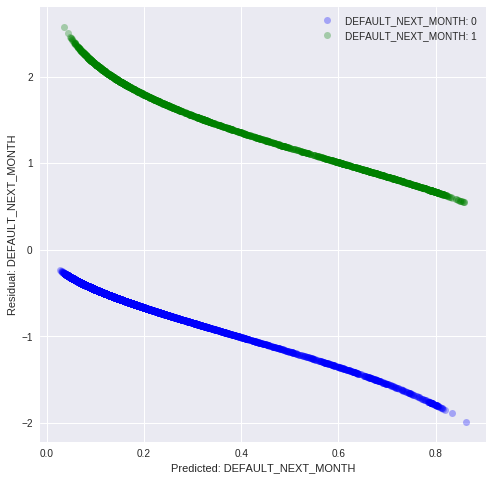

In [34]:
groups = test_yhat.groupby('DEFAULT_NEXT_MONTH') #Define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          #Initialize figure

plt.xlabel('Predicted: DEFAULT_NEXT_MONTH')
plt.ylabel('Residual: DEFAULT_NEXT_MONTH')

#Plot groups with appropriate color
color_list = ['b', 'g'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, label=' '.join(['DEFAULT_NEXT_MONTH:', str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) #Legend

### Sort data by residuals and display data and residuals
Printing a table with model inputs, actual target values, and model predictions sorted by residuals is another simple way to analyze residuals. Customers that defaulted, but were predicted not to, are listed at the top of the table below. Scroll to the bottom of the table to see the customers who were predicted to default, but then did not. These are the potential outliers pictured in the residual plot above (residual values < -1.83).

In [35]:
test_yhat = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,15689,280000,male,university,single,30,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,155284,10000,100000,7000,6000,10000,8000,1,0.036100,2.577382
1,5078,320000,female,university,married,29,pay duly,pay duly,pay duly,use of revolving credit,...,17257,7655,205211,6100,5000,2000,8000,1,0.043264,2.506162
2,6854,290000,male,high school,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,148820,1200,135000,5200,5500,5500,5400,1,0.048686,2.458605
3,16277,300000,female,graduate school,single,31,use of revolving credit,use of revolving credit,use of revolving credit,pay duly,...,12565,30000,5000,5045,10288,5000,5000,1,0.050229,2.445882
4,10650,400000,female,graduate school,single,27,no consumption,no consumption,no consumption,no consumption,...,16153,4460,5072,7048,52317,16232,4516,1,0.050371,2.444727
5,10671,410000,male,university,single,48,use of revolving credit,use of revolving credit,use of revolving credit,pay duly,...,18777,5422,3040,15362,17133,5076,4040,1,0.051102,2.438827
6,18899,140000,female,other,single,28,use of revolving credit,use of revolving credit,pay duly,use of revolving credit,...,141006,1000,6327,135000,4700,5000,5000,1,0.052460,2.428050
7,2348,260000,female,university,single,25,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,5651,5006,5000,5000,3491,3000,2000,1,0.054849,2.409636
8,4321,420000,female,graduate school,single,34,pay duly,pay duly,pay duly,pay duly,...,1503,6222,9723,1045,1042,1509,9215,1,0.056622,2.396398
9,19200,170000,female,university,single,32,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,...,740,6151,4110,6920,6637,0,16744,1,0.056878,2.394514


This simple analysis has uncovered some of the most difficult customers for the DAI model to correctly predict default. Perhaps because of the high importance of the encoded payment features, PAY_0, PAY_2, PAY_AMT1, PAY_3, PAY_AMT2, and LIMIT_BAL, the DAI model struggles to correctly predict several cases in which customers made timely recent payments and then suddenly defaulted (high positive residuals) and those customers that were chronically late making payments but did not default (high negative residuals).

### Plot residuals by most important input variable
Residuals can also be plotted for important input variables to understand how the values of a single input variable affect prediction errors. When plotted by the very important raw variable PAY_0, the residuals confirm that the DAI model is struggling to accurately predict cases where default status is not correlated with recent payment behavior in an obvious way. The residual plots for values of PAY_0 indicating timely payment behavior (e.g., use of revolving credit, pay duly, and no consumption) generally display the highest positive residuals and relatively small negative residuals. Residuals for the other values of PAY_0, those that represent late recent payments, tend to show large negative residuals and relatively small positive residuals.

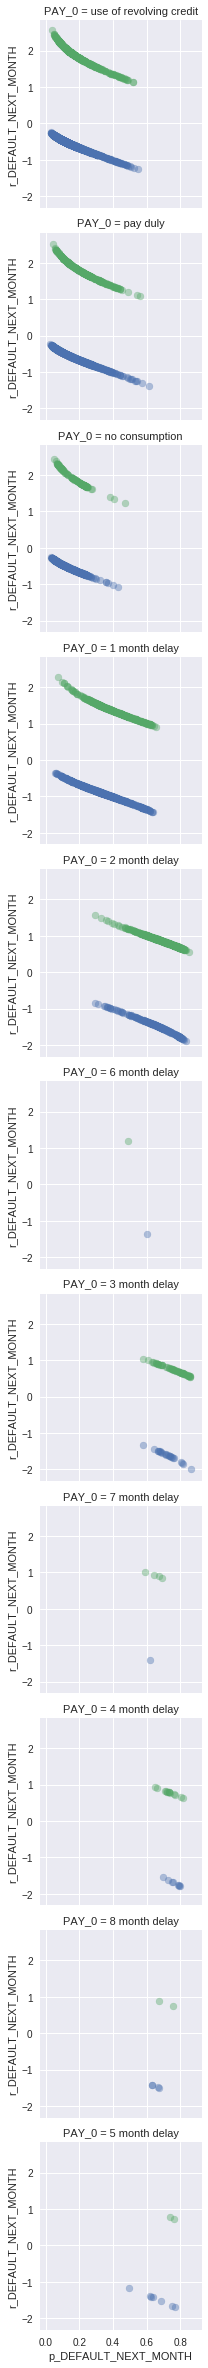

In [37]:
#Use Seaborn FacetGrid for convenience
g = sns.FacetGrid(test_yhat, row='PAY_0', hue=y)
_ = g.map(plt.scatter, yhat, 'r_DEFAULT_NEXT_MONTH', alpha=0.4)

## Summary
In this notebook, a DAI model was trained to predict credit card defaults. Residual analysis was used to debug the DAI model. Residual analysis is a powerful model debugging technique and can increase trust in complex models. This technique should generalize well for many types of business and research problems, enabling you to train a complex model and justify it to your colleagues, bosses, and potentially, external regulators.